ResNeXt

Setup environment

In [2]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
import torch.optim as optim
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda:", torch.cuda.is_available())

# Directory paths in the local machine
test_data_path = "./Dataset/test"
combined_data_path = "./Dataset/train"

# for reproducibility and quick adjustments
torch.manual_seed(0)
BATCH_SIZE = 32
num_epochs = 30


cuda: True


Prep the training and validation datasets

In [3]:

# Define the Transformations, with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# for validation without data augmentation
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset with training transform
full_dataset = datasets.ImageFolder(root=combined_data_path, transform=transform_train)

# Split the dataset into train and validation sets
num_train = len(full_dataset)
num_val = int(0.2 * num_train)
num_train -= num_val
train_subset, val_subset = random_split(full_dataset, [num_train, num_val])

# Set the transform for validation subset
val_subset.dataset.transform = transform_val

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False)

# Display training/validation set count
print(f"Training image count: {len(train_subset)}")
print(f"Validation image count: {len(val_subset)}")


Training image count: 972
Validation image count: 107


Prep the testing dataset

In [4]:
# Custom dataset loader to handle unlabeled data.
class UnlabeledDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_list[idx]

test_dataset = UnlabeledDataset(root_dir=test_data_path, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Setup Model with ResNeXt

In [5]:
# resnext = models.resnext50_32x4d(pretrained=True)
resnext = models.resnext101_32x8d(pretrained=True)

class MyModel(nn.Module):
    def __init__(self, resnext):
        super(MyModel, self).__init__()
        self.resnext = resnext
        num_features = resnext.fc.in_features  # Get the number of inputs for the last layer
        self.resnext.fc = nn.Identity() # Repace the last fc layer with a place holder

        # Freeze all pretrained layers
        for param in self.resnext.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # 50% of the neurons are dropped out
            nn.Linear(num_features, 100)
        )

    def forward(self, x):
        x = self.resnext(x)
        x = self.fc(x)
        return x

model = MyModel(resnext)
model = model.to(device)


C:\Users\Michael\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Michael\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Define Loss Function and Optimizer and scheduler

In [6]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2) # weight_decay is L2 regularization
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

Training and Validation Loop

In [7]:
# Keep track of training loss and validation accuracy
train_losses = []
val_accuracies = []

def update_augmentation(epoch):
    # Adjust the augmentation strategy here as needed
    if epoch % 10 == 0:
        new_transform_train = transforms.Compose([
            transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            # Additional augmentations can be added here
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        train_loader.dataset.dataset.transform = new_transform_train

for epoch in range(num_epochs):
    # Update the augmentation strategy based on epoch number
    update_augmentation(epoch)

    # Set the model to training mode
    model.train()
    
    # Track loss of each epoch
    total_loss = 0

    # Loop over each batch from the training set
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate average loss over an epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Set Model to Evaluation Mode
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_accuracy = 100 * correct / total
    val_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {epoch_accuracy:.2f}%')

    scheduler.step(total_loss / len(train_loader))
    

Epoch [1/30], Loss: 4.4028, Validation Accuracy: 17.76%
Epoch [2/30], Loss: 2.6336, Validation Accuracy: 37.38%
Epoch [3/30], Loss: 1.9428, Validation Accuracy: 41.12%
Epoch [4/30], Loss: 1.5878, Validation Accuracy: 46.73%
Epoch [5/30], Loss: 1.3331, Validation Accuracy: 49.53%
Epoch [6/30], Loss: 1.2138, Validation Accuracy: 47.66%
Epoch [7/30], Loss: 1.0918, Validation Accuracy: 51.40%
Epoch [8/30], Loss: 1.0308, Validation Accuracy: 52.34%
Epoch [9/30], Loss: 0.9270, Validation Accuracy: 51.40%
Epoch [10/30], Loss: 0.8729, Validation Accuracy: 55.14%
Epoch [11/30], Loss: 0.8534, Validation Accuracy: 50.47%
Epoch [12/30], Loss: 0.7678, Validation Accuracy: 51.40%
Epoch [13/30], Loss: 0.7726, Validation Accuracy: 52.34%
Epoch [14/30], Loss: 0.7362, Validation Accuracy: 56.07%
Epoch [15/30], Loss: 0.7156, Validation Accuracy: 58.88%
Epoch [16/30], Loss: 0.7208, Validation Accuracy: 51.40%
Epoch [17/30], Loss: 0.6707, Validation Accuracy: 57.01%
Epoch [18/30], Loss: 0.6565, Validation 

Plotting Training Loss and Training Accuracy

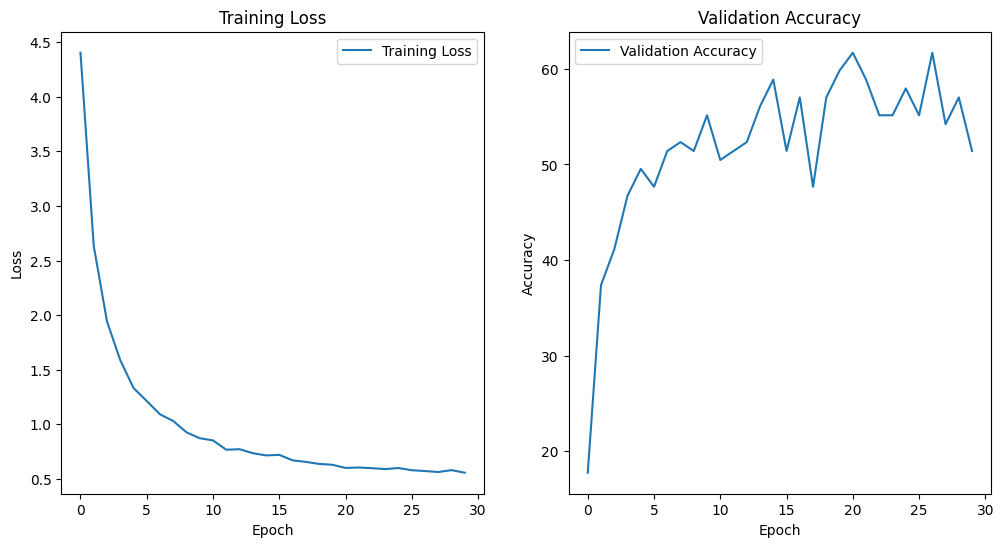

In [8]:
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


Eva;uate and create the predictions

In [9]:
# Model's evaluation mode
model.eval()

test_predictions = []

# Assuming the model is already in evaluation mode and device is defined
with torch.no_grad():
    for images, paths in tqdm(test_loader, desc='Predicting labels'):
        images = images.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels = [full_dataset.classes[p] for p in predicted.cpu().numpy()]

        # Go through the batch and add to our prediction list, including image paths
        for path, label in zip(paths, predicted_labels):
            test_predictions.append((Path(path).name, label))  # Appending a tuple of filename and label

with open('./CSV Files/submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'Label'])
    writer.writerows(test_predictions)  # Writing all predictions at once

Predicting labels: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s]
